# Task 5
In this task, I used a vision transformer model to perform binary classification using PyTorch. I created a config file, defined my hyperparameters and initiated the training process. This notebook will show  the evaluation metrics for binary classification

## Dataset preparation

Dataset has been split in the following way:
- Used Torch ImageFolderDataset class to create the dataset 
- Used Subset and sklearn train test split to split the dataset 90-10 ratio using stratification. Then on that 90% training set split again in 95-5 ratio for trainining and validation set.

More can be found on `utils/dataset.py`

In [2]:
from torchvision import transforms
import os
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import DatasetFolder,ImageFolder
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import roc_curve, auc
import torch.nn.functional as F 
from utils import get_model, generate_model_outputs, get_dataset_t5

In [ ]:
def get_dataset_t5(dataset_dir, batch_size = 16, shuffle = True):

    transform = transforms.Compose([transforms.ToTensor(), transforms.CenterCrop(100)])
    ds = ImageFolder(root=dataset_dir,transform=transform)

    train_idx, test_idx = train_test_split(
        np.arange(len(ds)), test_size=0.1, shuffle=shuffle, stratify=ds.targets
    )
    train_labels = ds.targets
    train_labels = np.array(train_labels)
    train_idx, val_idx = train_test_split(np.arange(len(train_idx)), test_size=0.05, shuffle=shuffle, stratify=train_labels[train_idx])

    train_ds = Subset(ds, indices=train_idx)
    val_ds = Subset(ds, indices=val_idx)
    test_ds = Subset(ds, indices=test_idx)

    # print(f"train_ds : {len(train_ds)}, val_ds: {len(val_ds)}, test_ds: {len(test_ds)}")
    train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle)
    val_dataloader = DataLoader(val_ds, batch_size=batch_size, shuffle=shuffle)
    test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=shuffle)

    return train_dataloader, val_dataloader, test_dataloader


## Create config file

In [ ]:
conf = """


exp:
    data_dir: /media/saitomar/Work/Projects/DeepLense_Test/task_5_dataset
    wandb: True
    wandb_api_key: /media/saitomar/Work/Projects/DeepLense_Test/api_key.txt
    proj_name: DeepLense
    exp_dir: ./runs
    exp_name: Task5-ViT-0.0.2
    device: cuda
    log_freq: 20  # steps
    log_to_file: False
    log_to_stdout: True
    val_freq: 1   # epochs
    n_workers: 1
    pin_memory: True
    cache: 2
    task: t5
entity: saitomar

hparams:
    restore_ckpt:
    seed: 0
    batch_size: 16
    start_epoch: 0
    n_epochs: 50
    l_smooth: 
    device: cuda
    num_classes: 2

    
    model:
        type : ViT
        ViT:
            image_size : 100
            patch_size : 10
            num_classes : 2
            dim : 128
            depth : 8
            heads : 4
            mlp_dim : 128
            pool : mean
    optimizer:
        opt_type: adamw
        opt_kwargs:
          lr: 0.005
          
    
    scheduler:
        n_warmup: 10
        max_epochs: 50
        scheduler_type: cosine_annealing

"""

with open("sample_config/config.yaml", "w+") as f:
    f.write(conf)

## Initiate training

In [ ]:
# !python3 pipeline.py --conf sample_config/config.yaml

## ROC curve and AUC score
### Load model ckpt

In [4]:
model_cfg_dict = {
    "type" : "ViT",
    "ViT" : {
        "image_size" : 100,
        "patch_size" : 10,
        "num_classes" : 3,
        "dim" : 128,
        "depth" : 8,
        "heads" : 4,
        "mlp_dim" : 128,
        "pool" : "mean"
    }
}

model = get_model(model_config=model_cfg_dict)
ckpt = torch.load(f='/media/saitomar/Work/Projects/DeepLense_Test/runs/Task5-ViT-0.0.2/last.pth')
model.load_state_dict(ckpt["model_state_dict"])

<All keys matched successfully>

### Prepare test_data_loader

In [5]:
root_dir = "/media/saitomar/Work/Projects/DeepLense_Test/task_5_dataset"

_, _, test_loader = get_dataset_t5(
        dataset_dir=root_dir
    )

In [12]:
true_labels, class_probs = generate_model_outputs(model=model, test_loader=test_loader, num_classes=2)


In [13]:
# Compute ROC curve and AUC score for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(true_labels, class_probs[i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])


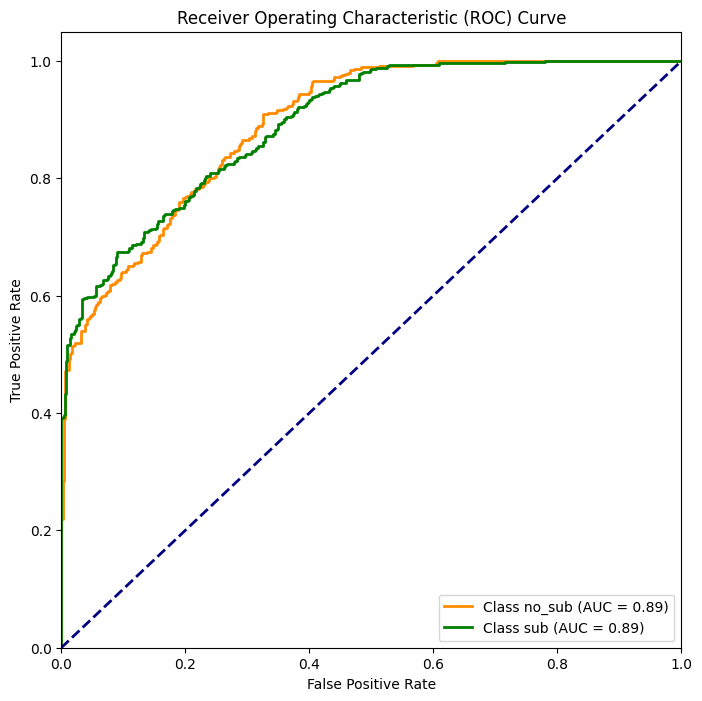

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.plot(fpr[0], tpr[0], color='darkorange', lw=2, label='Class no_sub (AUC = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='green', lw=2, label='Class sub (AUC = %0.2f)' % roc_auc[1])
# plt.plot(fpr[2], tpr[2], color='blue', lw=2, label='Class vort (AUC = %0.2f)' % roc_auc[2])
# plt.plot(fpr_micro, tpr_micro, color='gray', lw=2, linestyle='--', label='Micro-Averaged ROC (AUC = %0.2f)' % roc_auc_micro)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()